## Data Prep

In [3]:
import warnings
warnings.filterwarnings("ignore")
import joblib
import gc
import multiprocessing as mp
import numpy as np
import pandas as pd
import _pickle as cpickle
import seaborn as sns
import pickle
import lightgbm as lgb
from lightgbm.sklearn import LGBMClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, f1_score,roc_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

In [4]:
# Importing each csv files
orders = pd.read_csv("/Users/data/Desktop/instacart-market-basket-analysis/csvs/orders.csv")
order_products_train = pd.read_csv("/Users/data/Desktop/instacart-market-basket-analysis/csvs/order_products__train.csv")

In [5]:
# Importing features 
users_df =  pd.read_pickle("/Users/data/Desktop/Features@Library/Features/users_df.pkl")
products_df =  pd.read_pickle("/Users/data/Desktop/Features@Library/Features/products_df.pkl")
user_x_product =  pd.read_pickle("/Users/data/Desktop/Features@Library/Features/uxp_df.pkl")

In [6]:
# Merging user_x_product features with users features
data = user_x_product.merge(users_df, on='user_id', how='left')
data.head()


user_id  product_id  times_brought  uxp_total_reordered  \
0        1         196             10                    9   
1        1       10258              9                    8   
2        1       10326              1                    0   
3        1       12427             10                    9   
4        1       13032              3                    2   

   uxp_first_order_num  uxp_avg_cart_pos  uxp_min_cart_pos  uxp_max_cart_pos  \
0                    1          1.400000                 1                 4   
1                    2          3.333333                 2                 6   
2                    5          5.000000                 5                 5   
3                    1          3.300000                 1                 9   
4                    2          6.333333                 5                 8   

   uxp_median_cart_pos  uxp_last_order_num  ...  reordered_ratio  \
0                  1.0                  10  ...         0.694915   
1                  3.0                  10  ...         0.694915   
2                  5.0                   5  ...         0.694915   
3                  2.5                  10  ...         0.694915   
4                  6.0                  10  ...         0.694915   

   total_num_orders  user_total_prods  user_unique_prods  user_average_basket  \
0               343                59                 18             0.172012   
1               343                59                 18             0.172012   
2               343                59                 18             0.172012   
3               343                59                 18             0.172012   
4               343                59                 18             0.172012   

   user_order_starts_at  avg_no_prds_each_purchase  \
0                431534                        5.9   
1                431534                        5.9   
2                431534                        5.9   
3                431534                        5.9   
4                431534                        5.9   

   median_no_prds_each_purchase  min_no_prds_each_purchase  \
0                           5.5                          4   
1                           5.5                          4   
2                           5.5                          4   
3                           5.5                          4   
4                           5.5                          4   

   max_no_prds_each_purchase  
0                          9  
1                          9  
2                          9  
3                          9  
4                          9  

[5 rows x 37 columns]

In [7]:
# Merging product features with data.
data = data.merge(products_df, on='product_id', how='left')
data.head()

user_id  product_id  times_brought  uxp_total_reordered  \
0        1         196             10                    9   
1        1       10258              9                    8   
2        1       10326              1                    0   
3        1       12427             10                    9   
4        1       13032              3                    2   

   uxp_first_order_num  uxp_avg_cart_pos  uxp_min_cart_pos  uxp_max_cart_pos  \
0                    1          1.400000                 1                 4   
1                    2          3.333333                 2                 6   
2                    5          5.000000                 5                 5   
3                    1          3.300000                 1                 9   
4                    2          6.333333                 5                 8   

   uxp_median_cart_pos  uxp_last_order_num  ...  prod_tot_reorders  \
0                  1.0                  10  ...              27791   
1                  3.0                  10  ...               1389   
2                  5.0                   5  ...               3603   
3                  2.5                  10  ...               4797   
4                  6.0                  10  ...               2465   

   prod_reordered_ratio  avg_cart_position  median_cart_position  \
0              0.776480           3.721774                   2.0   
1              0.713772           4.277492                   3.0   
2              0.652009           4.191097                   3.0   
3              0.740735           4.760037                   3.0   
4              0.657158           5.622767                   4.0   

   sum_cart_position  min_cart_position  max_cart_position  std_cart_position  \
0             133206                  1                 60           4.110813   
1               8324                  1                 29           3.567502   
2              23160                  1                 37           3.611700   
3              30826                  1                 61           4.782450   
4              21091                  1                 66           5.345184   

   aisle_reorder_ratio  department_reorder_ratio  
0             0.638832                  0.653460  
1             0.519170                  0.574180  
2             0.718104                  0.649913  
3             0.591986                  0.574180  
4             0.571584                  0.560922  

[5 rows x 48 columns]

In [8]:
data.shape

(13307953, 48)

In [9]:
# Let's first get the future orders.(train and test eval_set)
future_orders = orders[((orders['eval_set'] == 'train') | (orders['eval_set'] == 'test'))]
future_orders.head()


order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
10   1187899        1    train            11          4                  8   
25   1492625        2    train            15          1                 11   
38   2774568        3     test            13          5                 15   
44    329954        4     test             6          3                 12   
49   2196797        5    train             5          0                 11   

    days_since_prior_order  
10                    14.0  
25                    30.0  
38                    11.0  
44                    30.0  
49                     6.0

In [10]:
future_orders = future_orders[['user_id','order_id','eval_set']]
future_orders.head()


user_id  order_id eval_set
10        1   1187899    train
25        2   1492625    train
38        3   2774568     test
44        4    329954     test
49        5   2196797    train

In [11]:
# Merging data with future orders
data = data.merge(future_orders,on='user_id',how='left')
data.head()


user_id  product_id  times_brought  uxp_total_reordered  \
0        1         196             10                    9   
1        1       10258              9                    8   
2        1       10326              1                    0   
3        1       12427             10                    9   
4        1       13032              3                    2   

   uxp_first_order_num  uxp_avg_cart_pos  uxp_min_cart_pos  uxp_max_cart_pos  \
0                    1          1.400000                 1                 4   
1                    2          3.333333                 2                 6   
2                    5          5.000000                 5                 5   
3                    1          3.300000                 1                 9   
4                    2          6.333333                 5                 8   

   uxp_median_cart_pos  uxp_last_order_num  ...  avg_cart_position  \
0                  1.0                  10  ...           3.721774   
1                  3.0                  10  ...           4.277492   
2                  5.0                   5  ...           4.191097   
3                  2.5                  10  ...           4.760037   
4                  6.0                  10  ...           5.622767   

   median_cart_position  sum_cart_position  min_cart_position  \
0                   2.0             133206                  1   
1                   3.0               8324                  1   
2                   3.0              23160                  1   
3                   3.0              30826                  1   
4                   4.0              21091                  1   

   max_cart_position  std_cart_position  aisle_reorder_ratio  \
0                 60           4.110813             0.638832   
1                 29           3.567502             0.519170   
2                 37           3.611700             0.718104   
3                 61           4.782450             0.591986   
4                 66           5.345184             0.571584   

   department_reorder_ratio  order_id  eval_set  
0                  0.653460   1187899     train  
1                  0.574180   1187899     train  
2                  0.649913   1187899     train  
3                  0.574180   1187899     train  
4                  0.560922   1187899     train  

[5 rows x 50 columns]

In [12]:
# Getting only the training data set
data_train = data[data['eval_set'] == 'train']
data_train.head()


user_id  product_id  times_brought  uxp_total_reordered  \
0        1         196             10                    9   
1        1       10258              9                    8   
2        1       10326              1                    0   
3        1       12427             10                    9   
4        1       13032              3                    2   

   uxp_first_order_num  uxp_avg_cart_pos  uxp_min_cart_pos  uxp_max_cart_pos  \
0                    1          1.400000                 1                 4   
1                    2          3.333333                 2                 6   
2                    5          5.000000                 5                 5   
3                    1          3.300000                 1                 9   
4                    2          6.333333                 5                 8   

   uxp_median_cart_pos  uxp_last_order_num  ...  avg_cart_position  \
0                  1.0                  10  ...           3.721774   
1                  3.0                  10  ...           4.277492   
2                  5.0                   5  ...           4.191097   
3                  2.5                  10  ...           4.760037   
4                  6.0                  10  ...           5.622767   

   median_cart_position  sum_cart_position  min_cart_position  \
0                   2.0             133206                  1   
1                   3.0               8324                  1   
2                   3.0              23160                  1   
3                   3.0              30826                  1   
4                   4.0              21091                  1   

   max_cart_position  std_cart_position  aisle_reorder_ratio  \
0                 60           4.110813             0.638832   
1                 29           3.567502             0.519170   
2                 37           3.611700             0.718104   
3                 61           4.782450             0.591986   
4                 66           5.345184             0.571584   

   department_reorder_ratio  order_id  eval_set  
0                  0.653460   1187899     train  
1                  0.574180   1187899     train  
2                  0.649913   1187899     train  
3                  0.574180   1187899     train  
4                  0.560922   1187899     train  

[5 rows x 50 columns]

In [13]:
# Merging the information contained in order_products_train csv with data_train
data_train = data_train.merge(order_products_train[['product_id','order_id','reordered']],on=['product_id','order_id'],how='left')
data_train.head()


user_id  product_id  times_brought  uxp_total_reordered  \
0        1         196             10                    9   
1        1       10258              9                    8   
2        1       10326              1                    0   
3        1       12427             10                    9   
4        1       13032              3                    2   

   uxp_first_order_num  uxp_avg_cart_pos  uxp_min_cart_pos  uxp_max_cart_pos  \
0                    1          1.400000                 1                 4   
1                    2          3.333333                 2                 6   
2                    5          5.000000                 5                 5   
3                    1          3.300000                 1                 9   
4                    2          6.333333                 5                 8   

   uxp_median_cart_pos  uxp_last_order_num  ...  median_cart_position  \
0                  1.0                  10  ...                   2.0   
1                  3.0                  10  ...                   3.0   
2                  5.0                   5  ...                   3.0   
3                  2.5                  10  ...                   3.0   
4                  6.0                  10  ...                   4.0   

   sum_cart_position  min_cart_position  max_cart_position  std_cart_position  \
0             133206                  1                 60           4.110813   
1               8324                  1                 29           3.567502   
2              23160                  1                 37           3.611700   
3              30826                  1                 61           4.782450   
4              21091                  1                 66           5.345184   

   aisle_reorder_ratio  department_reorder_ratio  order_id  eval_set  \
0             0.638832                  0.653460   1187899     train   
1             0.519170                  0.574180   1187899     train   
2             0.718104                  0.649913   1187899     train   
3             0.591986                  0.574180   1187899     train   
4             0.571584                  0.560922   1187899     train   

   reordered  
0        1.0  
1        1.0  
2        NaN  
3        NaN  
4        1.0  

[5 rows x 51 columns]

In [14]:
# replace Nan with 0 in data_train
data_train['reordered'].fillna(0,inplace=True)

In [15]:
# Setting the index for train data as a combination of user-id and product-id
data_train = data_train.set_index(['user_id','product_id'])

# Dropping the eval_set and order_id columns
data_train.drop(['eval_set','order_id'],axis=1,inplace=True)

#display
data_train.head()


times_brought  uxp_total_reordered  uxp_first_order_num  \
user_id product_id                                                            
1       196                    10                    9                    1   
        10258                   9                    8                    2   
        10326                   1                    0                    5   
        12427                  10                    9                    1   
        13032                   3                    2                    2   

                    uxp_avg_cart_pos  uxp_min_cart_pos  uxp_max_cart_pos  \
user_id product_id                                                         
1       196                 1.400000                 1                 4   
        10258               3.333333                 2                 6   
        10326               5.000000                 5                 5   
        12427               3.300000                 1                 9   
        13032               6.333333                 5                 8   

                    uxp_median_cart_pos  uxp_last_order_num  uxp_avg_dow  \
user_id product_id                                                         
1       196                         1.0                  10     2.500000   
        10258                       3.0                  10     2.555556   
        10326                       5.0                   5     4.000000   
        12427                       2.5                  10     2.500000   
        13032                       6.0                  10     2.666667   

                    uxp_median_dow  ...  prod_reordered_ratio  \
user_id product_id                  ...                         
1       196                    2.5  ...              0.776480   
        10258                  3.0  ...              0.713772   
        10326                  4.0  ...              0.652009   
        12427                  2.5  ...              0.740735   
        13032                  3.0  ...              0.657158   

                    avg_cart_position  median_cart_position  \
user_id product_id                                            
1       196                  3.721774                   2.0   
        10258                4.277492                   3.0   
        10326                4.191097                   3.0   
        12427                4.760037                   3.0   
        13032                5.622767                   4.0   

                    sum_cart_position  min_cart_position  max_cart_position  \
user_id product_id                                                            
1       196                    133206                  1                 60   
        10258                    8324                  1                 29   
        10326                   23160                  1                 37   
        12427                   30826                  1                 61   
        13032                   21091                  1                 66   

                    std_cart_position  aisle_reorder_ratio  \
user_id product_id                                           
1       196                  4.110813             0.638832   
        10258                3.567502             0.519170   
        10326                3.611700             0.718104   
        12427                4.782450             0.591986   
        13032                5.345184             0.571584   

                    department_reorder_ratio  reordered  
user_id product_id                                       
1       196                         0.653460        1.0  
        10258                       0.574180        1.0  
        10326                       0.649913        0.0  
        12427                       0.574180        0.0  
        13032                       0.560922        1.0  

[5 rows x 47 columns]

In [16]:
# following same steps as above for test data

data_test = data[data['eval_set'] == 'test']
data_test.head()

# Setting the index for train data as a combination of user-id and product-id
data_test = data_test.set_index(['user_id','product_id'])

# Dropping the eval_set and order_id columns
data_test.drop(['eval_set','order_id'],axis=1,inplace=True)

#display
data_test.head()


times_brought  uxp_total_reordered  uxp_first_order_num  \
user_id product_id                                                            
3       248                     1                    0                    2   
        1005                    1                    0                   10   
        1819                    3                    2                    4   
        7503                    1                    0                    3   
        8021                    1                    0                    2   

                    uxp_avg_cart_pos  uxp_min_cart_pos  uxp_max_cart_pos  \
user_id product_id                                                         
3       248                 3.000000                 3                 3   
        1005                5.000000                 5                 5   
        1819                2.666667                 1                 5   
        7503                6.000000                 6                 6   
        8021                5.000000                 5                 5   

                    uxp_median_cart_pos  uxp_last_order_num  uxp_avg_dow  \
user_id product_id                                                         
3       248                         3.0                   2     3.000000   
        1005                        5.0                  10     3.000000   
        1819                        2.0                   7     0.666667   
        7503                        6.0                   3     3.000000   
        8021                        5.0                   2     3.000000   

                    uxp_median_dow  ...  prod_tot_reorders  \
user_id product_id                  ...                      
3       248                    3.0  ...               2550   
        1005                   3.0  ...                204   
        1819                   0.0  ...               1193   
        7503                   3.0  ...               6905   
        8021                   3.0  ...              16472   

                    prod_reordered_ratio  avg_cart_position  \
user_id product_id                                            
3       248                     0.400251          10.620782   
        1005                    0.440605           9.498920   
        1819                    0.492162           9.287541   
        7503                    0.553551           9.547379   
        8021                    0.591157           8.822854   

                    median_cart_position  sum_cart_position  \
user_id product_id                                            
3       248                          9.0              67665   
        1005                         8.0               4398   
        1819                         7.0              22513   
        7503                         8.0             119094   
        8021                         7.0             245840   

                    min_cart_position  max_cart_position  std_cart_position  \
user_id product_id                                                            
3       248                         1                 91           8.025390   
        1005                        1                 74           7.984800   
        1819                        1                 68           7.441465   
        7503                        1                 79           7.622521   
        8021                        1                 90           7.211007   

                    aisle_reorder_ratio  department_reorder_ratio  
user_id product_id                                                 
3       248                    0.519170                  0.574180  
        1005                   0.527615                  0.653460  
        1819                   0.487633                  0.346721  
        7503                   0.519170                  0.574180  
        8021                   0.528005                  0.402178  

[5 rows x 46 columns]

In [17]:
print("Train data shape - ",data_train.shape)
print("Test data shape - ",data_test.shape)


Train data shape -  (8474661, 47)
Test data shape -  (4833292, 46)


In [18]:
# Deleting unwanted data frames
del [data,future_orders,orders]


In [19]:
from sklearn.model_selection import train_test_split
from downcast import reduce

# replace Nan values with mean values
data_train.fillna(data_train.mean(), inplace=True)
data_train = reduce(data_train)

# Creating X and y(target variable)
X = data_train.drop(['reordered','min_number_of_orders'], axis=1)
y = data_train['reordered']

#replace Nan values with mean values
#X.fillna(X.mean(), inplace=True)


In [20]:
#splitting dataset into train and test split.
X.fillna(X.mean(), inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10,stratify=y)


In [21]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(5932262, 45)
(5932262,)
(2542399, 45)
(2542399,)


In [46]:
X_train.to_pickle('/Users/data/Desktop/Features@Library/X_train.pkl')
y_train.to_pickle('/Users/data/Desktop/Features@Library/y_train.pkl')
X_test.to_pickle('/Users/data/Desktop/Features@Library/X_test.pkl')
y_test.to_pickle('/Users/data/Desktop/Features@Library/y_test.pkl')


In [110]:
with open('/Users/data/Desktop/Features@Library/data_train.pkl', 'wb') as file:
    pickle.dump(data_train, file)

# data_test veri setini kaydetme
with open('/Users/data/Desktop/Features@Library/data_test.pkl', 'wb') as file:
    pickle.dump(data_test, file)

## Feature Importance

In [20]:
import pdb
from sklearn.ensemble import RandomForestClassifier
def get_imp_features(data,data_y,features):
    clf = RandomForestClassifier(n_estimators=100,n_jobs=-1,verbose=10)
    clf.fit(data,data_y)
    imp_feature_indexes = np.argsort(clf.feature_importances_)[::-1]
    top_30_indexes = imp_feature_indexes[:30]
    feature_imp_values = np.take(clf.feature_importances_,top_30_indexes)
    feature_imp_names = np.take(features,top_30_indexes)
    return feature_imp_values,feature_imp_names,top_30_indexes


In [21]:
features = X_train.columns.tolist()
feature_imp_values,feature_imp_names,top_30_indexes = get_imp_features(X_train,y_train, features)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   38.8s


building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min


building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.4min


building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.5min


building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.2min


building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.9min


building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.5min


building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  5.8min


building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  6.9min


building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  7.6min remaining:   19.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.0min finished


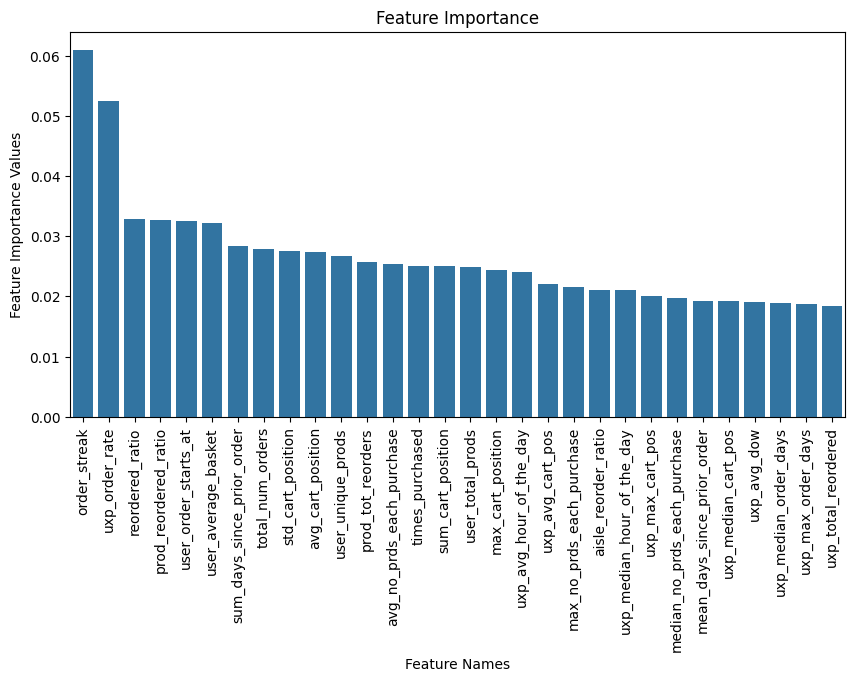

In [22]:
plt.figure(figsize = (10, 5))
ax = sns.barplot(x = feature_imp_names, y = feature_imp_values)
ax.set_xticklabels(labels = feature_imp_names, rotation = 90)
sns.set_palette(reversed(sns.color_palette("husl", 10)), 10)
plt.title('Feature Importance')
plt.xlabel('Feature Names')
plt.ylabel('Feature Importance Values')
plt.show()


In [22]:
# Taken from Facebook Recomendation system case study

def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()


### Veri Setini %80 oranında küçült

In [23]:
from sklearn.model_selection import train_test_split

# X_train ve y_train veri setlerinizi yükleyin
# X_train = ...
# y_train = ...

# Stratified sampling uygulayarak veri setini %20'ye düşürün
X_train_strat, X_discard, y_train_strat, y_discard = train_test_split(
    X_train, y_train, test_size=0.8, stratify=y_train, random_state=42)

# Sonuçların boyutlarını kontrol etme
print(X_train_strat.shape)
print(y_train_strat.shape)

(1186452, 45)
(1186452,)


In [24]:
X_train = X_train_strat
y_train = y_train_strat

In [25]:
y_train.value_counts()

reordered
0.0    1070417
1.0     116035
Name: count, dtype: int64

In [51]:
from sklearn.model_selection import RandomizedSearchCV

params = {'C' : [0.001,0.01,1,10] }

lr_model=LogisticRegression(penalty='l2',class_weight='balanced')
random_cfl_log=RandomizedSearchCV(lr_model,param_distributions=params,verbose=10,cv=4)
random_cfl.fit(X_train,y_train)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV 1/4; 1/4] START C=0.001.....................................................
[CV 1/4; 1/4] END ......................C=0.001;, score=0.653 total time=   7.8s
[CV 2/4; 1/4] START C=0.001.....................................................
[CV 2/4; 1/4] END ......................C=0.001;, score=0.655 total time=   7.8s
[CV 3/4; 1/4] START C=0.001.....................................................
[CV 3/4; 1/4] END ......................C=0.001;, score=0.559 total time=   7.4s
[CV 4/4; 1/4] START C=0.001.....................................................
[CV 4/4; 1/4] END ......................C=0.001;, score=0.661 total time=   7.1s
[CV 1/4; 2/4] START C=0.01......................................................
[CV 1/4; 2/4] END .......................C=0.01;, score=0.660 total time=   7.4s
[CV 2/4; 2/4] START C=0.01......................................................
[CV 2/4; 2/4] END .......................C=0.01;,

RandomizedSearchCV(cv=4, estimator=LogisticRegression(class_weight='balanced'),
                   param_distributions={'C': [0.001, 0.01, 1, 10]}, verbose=10)

In [52]:
# Best Paramaters
random_cfl.best_params_


{'C': 10}

In [55]:
from sklearn.model_selection import RandomizedSearchCV

params = {'C' : [10,12,15,20] }

lr_model=LogisticRegression(penalty='l2',class_weight='balanced')
random_cfl=RandomizedSearchCV(lr_model,param_distributions=params,verbose=10,cv=4)
random_cfl.fit(X_train,y_train)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV 1/4; 1/4] START C=10........................................................
[CV 1/4; 1/4] END .........................C=10;, score=0.653 total time=   6.6s
[CV 2/4; 1/4] START C=10........................................................
[CV 2/4; 1/4] END .........................C=10;, score=0.675 total time=   7.4s
[CV 3/4; 1/4] START C=10........................................................
[CV 3/4; 1/4] END .........................C=10;, score=0.559 total time=   7.4s
[CV 4/4; 1/4] START C=10........................................................
[CV 4/4; 1/4] END .........................C=10;, score=0.676 total time=   7.3s
[CV 1/4; 2/4] START C=12........................................................
[CV 1/4; 2/4] END .........................C=12;, score=0.653 total time=   7.8s
[CV 2/4; 2/4] START C=12........................................................
[CV 2/4; 2/4] END .........................C=12;,

RandomizedSearchCV(cv=4, estimator=LogisticRegression(class_weight='balanced'),
                   param_distributions={'C': [10, 12, 15, 20]}, verbose=10)

In [56]:
# Best Paramaters
random_cfl.best_params_


{'C': 10}

In [57]:
# To get the best threshold for max F1 score


lr_model = LogisticRegression(C=10)
lr_model.fit(X_train, y_train)
thresholds = lr_model.predict_proba(X_test)[:, 1]


In [59]:
# To check the mean and standard deviation of thresholds 
mean = np.mean(thresholds)
std = np.std(thresholds)


In [60]:
# To get the range of threshold values to calculate f1 score
print(mean)
print(std)
print(mean+2*std)
print(mean-2*std)


0.10863330659842166
0.078420646848048
0.26547460029451764
-0.04820798709767435


In [62]:
# Taking np.arange(0,1,0.02) would take a long time to finish execution. An easier 
# way would be to use the spread of thresholds to determine the best threshold
threshold_values = np.arange(mean-2*std,mean+2*std,0.02)
f1_scores = []
for threshold in threshold_values:
    y_pred = (lr_model.predict_proba(X_test)[:, 1] >= threshold).astype('int')
    f1_scores.append(f1_score(y_test , y_pred))


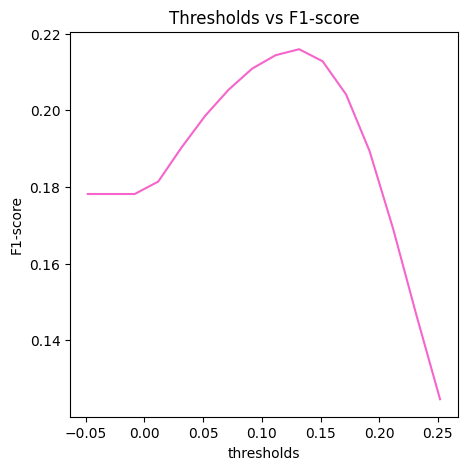

In [64]:
plt.figure(figsize=(5,5))
sns.lineplot(x=threshold_values , y=f1_scores)
plt.xlabel("thresholds")
plt.ylabel("F1-score")
plt.title("Thresholds vs F1-score")

plt.show()


In [65]:
print('Best threshold: ', threshold_values[np.argmax(f1_scores)])
print('Best F1-Score: ', np.max(f1_scores))


Best threshold:  0.13179201290232564
Best F1-Score:  0.2159429959956551


Train F1 Score: 0.21505750168890223
Validation F1 Score: 0.2159709853119595
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.69      0.92      0.79   1706354
           1       0.47      0.14      0.22    836045

    accuracy                           0.67   2542399
   macro avg       0.58      0.53      0.50   2542399
weighted avg       0.62      0.67      0.60   2542399

--------------------------------------------------


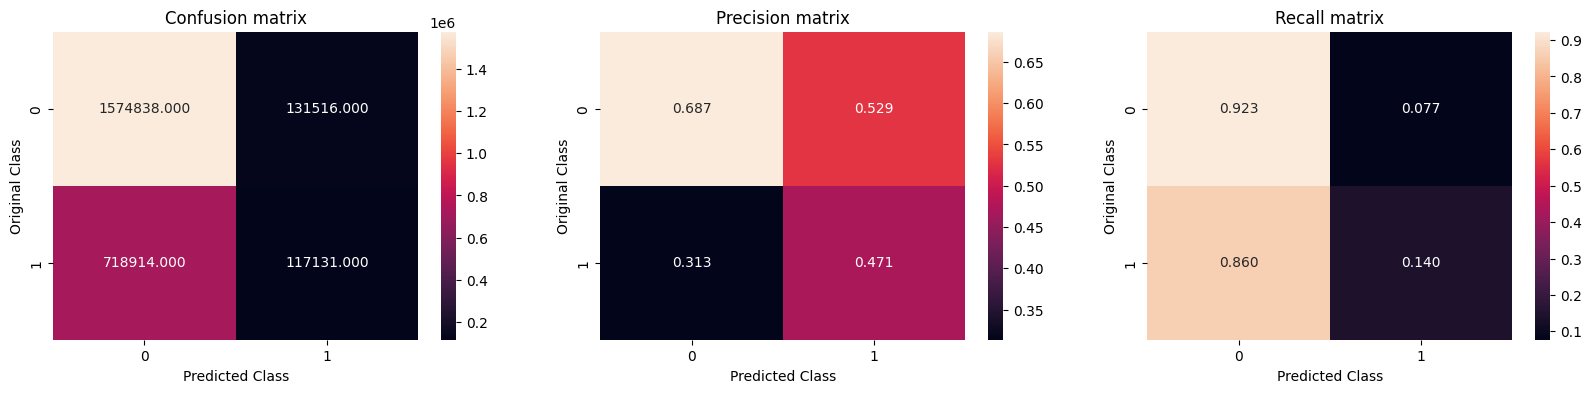

In [67]:
lr_model = LogisticRegression(C=10)
lr_model.fit(X_train, y_train)

train_pred_y = (lr_model.predict_proba(X_train)[:, 1] >= 0.1317).astype('int')
test_pred_y = (lr_model.predict_proba(X_test)[:, 1] >= 0.1317).astype('int')

f1_train = f1_score(train_pred_y, y_train)
f1_test = f1_score(test_pred_y, y_test)

print("Train F1 Score:", f1_train)
print("Validation F1 Score:", f1_test)
print("-"*50)
print(classification_report(test_pred_y, y_test))
print("-"*50)
plot_confusion_matrix(test_pred_y, y_test)


In [68]:
X_train_strat.to_pickle('/Users/data/Desktop/Features@Library/X_train_strat.pkl')
y_train_strat.to_pickle('/Users/data/Desktop/Features@Library/y_train_strat.pkl')

## XG boost

In [26]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

params = {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

xgb_model = XGBClassifier(tree_method='auto')
random_cfl=RandomizedSearchCV(xgb_model,param_distributions=params,verbose=10,cv=3)
random_cfl.fit(X_train,y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3; 1/10] START colsample_bytree=0.4, gamma=0.0, learning_rate=0.25, max_depth=8, min_child_weight=5
[CV 1/3; 1/10] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.25, max_depth=8, min_child_weight=5;, score=0.908 total time=   3.6s
[CV 2/3; 1/10] START colsample_bytree=0.4, gamma=0.0, learning_rate=0.25, max_depth=8, min_child_weight=5
[CV 2/3; 1/10] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.25, max_depth=8, min_child_weight=5;, score=0.909 total time=   3.5s
[CV 3/3; 1/10] START colsample_bytree=0.4, gamma=0.0, learning_rate=0.25, max_depth=8, min_child_weight=5
[CV 3/3; 1/10] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.25, max_depth=8, min_child_weight=5;, score=0.909 total time=   3.7s
[CV 1/3; 2/10] START colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=7
[CV 1/3; 2/10] END colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=7;, 

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7]},
                   verbose=10)

In [74]:
#Best Paramaters
random_cfl.best_params_

{'min_child_weight': 5,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 0.0,
 'colsample_bytree': 0.7}

In [27]:
params = {
    "learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    "max_depth": [3, 4, 5, 6, 8, 10, 12, 15],
    "min_child_weight": [1, 3, 5, 7],
    "gamma": [0.0, 0.1, 0.2, 0.3, 0.4],
    "colsample_bytree": [0.3, 0.4, 0.5, 0.7]
}

xgb_model = XGBClassifier(tree_method='auto')

# Grid Search modelini oluşturun
grid_search = GridSearchCV(xgb_model, param_grid=params, verbose=10, cv=3)

# Grid Search modelini eğitin
grid_search.fit(X_train, y_train)

# En iyi parametreleri ve en iyi skoru yazdırın
print("En İyi Parametreler:", grid_search.best_params_)
print("En İyi Skor:", grid_search.best_score_)


Fitting 3 folds for each of 3840 candidates, totalling 11520 fits
[CV 1/3; 1/3840] START colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1
[CV 1/3; 1/3840] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1;, score=0.908 total time=   2.4s
[CV 2/3; 1/3840] START colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1
[CV 2/3; 1/3840] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1;, score=0.909 total time=   2.5s
[CV 3/3; 1/3840] START colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1
[CV 3/3; 1/3840] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1;, score=0.909 total time=   2.5s
[CV 1/3; 2/3840] START colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3
[CV 1/3; 2/3840] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3

En İyi Parametreler: {'colsample_bytree': 0.7, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1}

In [76]:
# To get the best threshold for max F1 score

# Initializing the model
xgb_model = XGBClassifier(tree_method='auto',max_depth=8,colsample_bytree=0.7,gamma=0.0,learning_rate=0.1,min_child_weight=5)
xgb_model.fit(X_train,y_train)


thresholds = xgb_model.predict_proba(X_test)[:, 1]
# To check the mean and standard deviation of thresholds 
mean = np.mean(thresholds)
std = np.std(thresholds)
# To get the range of threshold values to calculate f1 score
print(mean)
print(std)
print(mean+2*std)
print(mean-2*std)


0.09780043
0.13200349
0.3618074059486389
-0.16620653867721558


In [79]:
# Taking np.arange(0,1,0.02) would take a long time to finish execution. An easier 
# way would be to use the spread of thresholds to determine the best threshold
threshold_values = np.arange(mean-2*std,mean+2*std,0.02)
f1_scores = []
for threshold in threshold_values:
    y_pred = (xgb_model.predict_proba(X_test)[:, 1] >= threshold).astype('int')
    f1_scores.append(f1_score(y_test , y_pred))


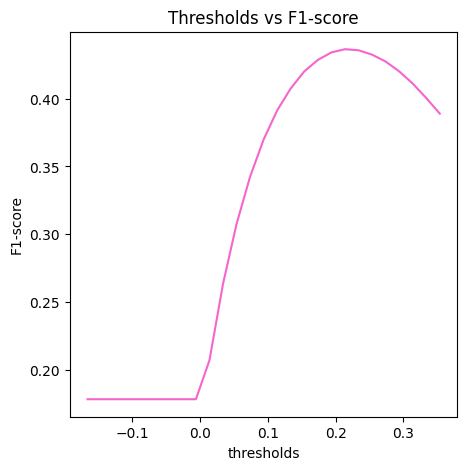

In [81]:
plt.figure(figsize=(5,5))
sns.lineplot(x=threshold_values , y=f1_scores)
plt.xlabel("thresholds")
plt.ylabel("F1-score")
plt.title("Thresholds vs F1-score")

plt.show()


In [82]:
print('Best threshold: ', threshold_values[np.argmax(f1_scores)])
print('Best F1-Score: ', np.max(f1_scores))


Best threshold:  0.2137934613227842
Best F1-Score:  0.4365739218480071


In [85]:
# Creating a  xgboost model.
from sklearn.metrics import f1_score, classification_report
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

# Initializing the model
xgb_model = XGBClassifier(tree_method='auto',max_depth=8,colsample_bytree=0.7,gamma=0.0,learning_rate=0.1,min_child_weight=5)

#fitting the model.
xgb_model.fit(X_train, y_train)

#prediction
y_pred_train = (xgb_model.predict_proba(X_train)[:, 1] >= 0.2137).astype('int') #setting a threshold.
y_pred_test = (xgb_model.predict_proba(X_test)[:, 1] >= 0.2137).astype('int') #setting a threshold.

#Evaluation.
print('Train F1 Score: {}'.format(f1_score(y_pred_train, y_train)))
print('Validation F1 Score: {}'.format(f1_score(y_pred_test, y_test)))
print("-"*50)
print(classification_report(y_pred_test, y_test))


Train F1 Score: 0.45882747318236
Validation F1 Score: 0.4365816288376154
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.94      0.93   2216047
           1       0.50      0.38      0.44    326352

    accuracy                           0.87   2542399
   macro avg       0.71      0.66      0.68   2542399
weighted avg       0.86      0.87      0.87   2542399



XG BOOST WITH GRID SEARCH

In [29]:
# To get the best threshold for max F1 score

# Initializing the model
xgb_model = XGBClassifier(tree_method='auto',max_depth=6,colsample_bytree=0.7,gamma=0.0,learning_rate=0.1,min_child_weight=1)
xgb_model.fit(X_train,y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [31]:
# To get the best threshold for max F1 score

# Initializing the model
xgb_model = XGBClassifier(tree_method='auto',max_depth=8,colsample_bytree=0.7,gamma=0.0,learning_rate=0.1,min_child_weight=5)
xgb_model.fit(X_train,y_train)


thresholds = xgb_model.predict_proba(X_test)[:, 1]
# To check the mean and standard deviation of thresholds 
mean = np.mean(thresholds)
std = np.std(thresholds)
# To get the range of threshold values to calculate f1 score
print(mean)
print(std)
print(mean+2*std)
print(mean-2*std)


0.09780043
0.13200349
0.3618074059486389
-0.16620653867721558


In [32]:
# Taking np.arange(0,1,0.02) would take a long time to finish execution. An easier 
# way would be to use the spread of thresholds to determine the best threshold
threshold_values = np.arange(mean-2*std,mean+2*std,0.02)
f1_scores = []
for threshold in threshold_values:
    y_pred = (xgb_model.predict_proba(X_test)[:, 1] >= threshold).astype('int')
    f1_scores.append(f1_score(y_test , y_pred))


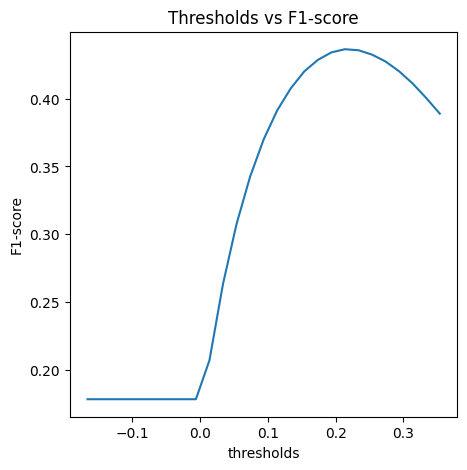

In [33]:
plt.figure(figsize=(5,5))
sns.lineplot(x=threshold_values , y=f1_scores)
plt.xlabel("thresholds")
plt.ylabel("F1-score")
plt.title("Thresholds vs F1-score")

plt.show()


In [34]:
print('Best threshold: ', threshold_values[np.argmax(f1_scores)])
print('Best F1-Score: ', np.max(f1_scores))

Best threshold:  0.2137934613227842
Best F1-Score:  0.4365739218480071


In [35]:
# Creating a  xgboost model.
from sklearn.metrics import f1_score, classification_report
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

# Initializing the model
xgb_model = XGBClassifier(tree_method='auto',max_depth=6,colsample_bytree=0.7,gamma=0.0,learning_rate=0.1,min_child_weight=1)

#fitting the model.
xgb_model.fit(X_train, y_train)

#prediction
y_pred_train = (xgb_model.predict_proba(X_train)[:, 1] >= 0.2137).astype('int') #setting a threshold.
y_pred_test = (xgb_model.predict_proba(X_test)[:, 1] >= 0.2137).astype('int') #setting a threshold.

#Evaluation.
print('Train F1 Score: {}'.format(f1_score(y_pred_train, y_train)))
print('Validation F1 Score: {}'.format(f1_score(y_pred_test, y_test)))
print("-"*50)
print(classification_report(y_pred_test, y_test))

Train F1 Score: 0.4432066038052415
Validation F1 Score: 0.4356218507140557
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.94      0.93   2216511
           1       0.50      0.38      0.44    325888

    accuracy                           0.87   2542399
   macro avg       0.71      0.66      0.68   2542399
weighted avg       0.86      0.87      0.86   2542399



In [37]:
pickle.dump(xgb_model, open("/Users/data/Desktop/Features@Library/XG@libray_grid", 'wb'))

In [24]:
X_train = X_train_strat
y_train = y_train_strat

In [31]:
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier

params = {'depth':[3,4,5,7,8,10,12],
          'iterations':[250,100,500,1000]}

cbc_model=CatBoostClassifier(boosting_type='Plain',bootstrap_type='Bernoulli',use_best_model=False)
random_cfl=RandomizedSearchCV(cbc_model,param_distributions=params,verbose=10,cv=3)
y_train = y_train.astype('int')
random_cfl.fit(X_train,y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3; 1/10] START depth=3, iterations=500....................................
Learning rate set to 0.336118
0:	learn: 0.4107665	total: 102ms	remaining: 50.8s
1:	learn: 0.3152290	total: 137ms	remaining: 34.1s
2:	learn: 0.2858917	total: 172ms	remaining: 28.4s
3:	learn: 0.2726394	total: 208ms	remaining: 25.8s
4:	learn: 0.2643359	total: 242ms	remaining: 23.9s
5:	learn: 0.2583544	total: 275ms	remaining: 22.6s
6:	learn: 0.2563889	total: 313ms	remaining: 22.1s
7:	learn: 0.2552909	total: 347ms	remaining: 21.3s
8:	learn: 0.2539603	total: 381ms	remaining: 20.8s
9:	learn: 0.2534601	total: 418ms	remaining: 20.5s
10:	learn: 0.2531365	total: 474ms	remaining: 21.1s
11:	learn: 0.2527162	total: 520ms	remaining: 21.1s
12:	learn: 0.2523869	total: 550ms	remaining: 20.6s
13:	learn: 0.2521554	total: 580ms	remaining: 20.1s
14:	learn: 0.2519870	total: 610ms	remaining: 19.7s
15:	learn: 0.2517148	total: 678ms	remaining: 20.5s
16:	learn: 0.2515121	t

RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostClassifier object at 0x17c3c3550>,
                   param_distributions={'depth': [3, 4, 5, 7, 8, 10, 12],
                                        'iterations': [250, 100, 500, 1000]},
                   verbose=10)

In [34]:
random_cfl.best_params_


{'iterations': 1000, 'depth': 3}

In [37]:
# To get the best threshold for max F1 score

# Initializing the model
catboost_model = CatBoostClassifier(depth=3,iterations=1000,use_best_model=False)
y_train = y_train.astype('int')
catboost_model.fit(X_train,y_train)
thresholds = catboost_model.predict_proba(X_test)[:, 1]


Learning rate set to 0.21166
0:	learn: 0.4948099	total: 53.8ms	remaining: 53.7s
1:	learn: 0.3887327	total: 99ms	remaining: 49.4s
2:	learn: 0.3363997	total: 147ms	remaining: 48.8s
3:	learn: 0.3051550	total: 197ms	remaining: 49.1s
4:	learn: 0.2853420	total: 245ms	remaining: 48.7s
5:	learn: 0.2748611	total: 292ms	remaining: 48.3s
6:	learn: 0.2681934	total: 338ms	remaining: 47.9s
7:	learn: 0.2637951	total: 387ms	remaining: 48s
8:	learn: 0.2600962	total: 430ms	remaining: 47.4s
9:	learn: 0.2584813	total: 476ms	remaining: 47.1s
10:	learn: 0.2565121	total: 521ms	remaining: 46.9s
11:	learn: 0.2555238	total: 567ms	remaining: 46.7s
12:	learn: 0.2546639	total: 610ms	remaining: 46.3s
13:	learn: 0.2540309	total: 655ms	remaining: 46.1s
14:	learn: 0.2536530	total: 697ms	remaining: 45.8s
15:	learn: 0.2531792	total: 740ms	remaining: 45.5s
16:	learn: 0.2528592	total: 783ms	remaining: 45.3s
17:	learn: 0.2526722	total: 829ms	remaining: 45.2s
18:	learn: 0.2524500	total: 875ms	remaining: 45.2s
19:	learn: 0.2

In [38]:
# To check the mean and standard deviation of thresholds 
mean = np.mean(thresholds)
std = np.std(thresholds)


In [39]:
# To get the range of threshold values to calculate f1 score
print(mean)
print(std)
print(mean+2*std)
print(mean-2*std)


0.09782605056173461
0.13236063781409282
0.36254732618992025
-0.16689522506645105


In [40]:
# Taking np.arange(0,1,0.02) would take a long time to finish execution. An easier 
# way would be to use the spread of thresholds to determine the best threshold
threshold_values = np.arange(mean-2*std,mean+2*std,0.02)
f1_scores = []
for threshold in threshold_values:
    y_pred = (catboost_model.predict_proba(X_test)[:, 1] >= threshold).astype('int')
    f1_scores.append(f1_score(y_test , y_pred))


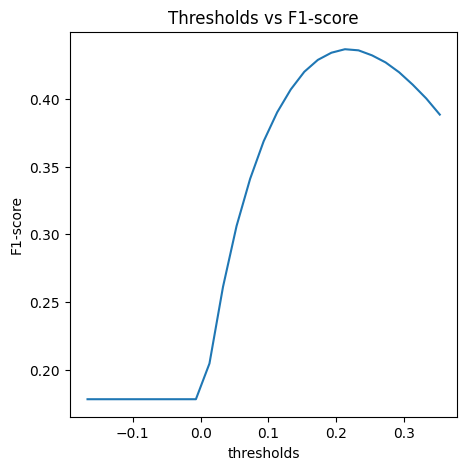

In [41]:
plt.figure(figsize=(5,5))
sns.lineplot(x = threshold_values , y = f1_scores)
plt.xlabel("thresholds")
plt.ylabel("F1-score")
plt.title("Thresholds vs F1-score")

plt.show()


In [42]:
print('Best threshold: ', threshold_values[np.argmax(f1_scores)])
print('Best F1-Score: ', np.max(f1_scores))


Best threshold:  0.21310477493354874
Best F1-Score:  0.43672016434374894


In [51]:
# Initializing the model
catboost_model = CatBoostClassifier(depth=3,iterations=1000,use_best_model=False)

#fitting the model.
y_train = y_train.astype('int')
catboost_model.fit(X_train, y_train)

#prediction
y_pred_train = (catboost_model.predict_proba(X_train)[:, 1] >= 0.213).astype('int') #setting a threshold.
y_pred_test = (catboost_model.predict_proba(X_test)[:, 1] >= 0.213).astype('int') #setting a threshold.


Learning rate set to 0.21166
0:	learn: 0.4948099	total: 58ms	remaining: 58s
1:	learn: 0.3887327	total: 105ms	remaining: 52.4s
2:	learn: 0.3363997	total: 152ms	remaining: 50.7s
3:	learn: 0.3051550	total: 210ms	remaining: 52.4s
4:	learn: 0.2853420	total: 263ms	remaining: 52.3s
5:	learn: 0.2748611	total: 310ms	remaining: 51.4s
6:	learn: 0.2681934	total: 359ms	remaining: 51s
7:	learn: 0.2637951	total: 425ms	remaining: 52.7s
8:	learn: 0.2600962	total: 478ms	remaining: 52.7s
9:	learn: 0.2584813	total: 526ms	remaining: 52.1s
10:	learn: 0.2565121	total: 575ms	remaining: 51.7s
11:	learn: 0.2555238	total: 623ms	remaining: 51.3s
12:	learn: 0.2546639	total: 678ms	remaining: 51.5s
13:	learn: 0.2540309	total: 727ms	remaining: 51.2s
14:	learn: 0.2536530	total: 775ms	remaining: 50.9s
15:	learn: 0.2531792	total: 822ms	remaining: 50.6s
16:	learn: 0.2528592	total: 867ms	remaining: 50.1s
17:	learn: 0.2526722	total: 916ms	remaining: 50s
18:	learn: 0.2524500	total: 964ms	remaining: 49.8s
19:	learn: 0.252158

In [52]:
#Evaluation.
print('Train F1 Score: {}'.format(f1_score(y_pred_train, y_train)))
print('Validation F1 Score: {}'.format(f1_score(y_pred_test, y_test)))
print("-"*50)
print(classification_report(y_pred_test, y_test))


Train F1 Score: 0.4442155391838532
Validation F1 Score: 0.43671433971006013
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.94      0.93   2216927
           1       0.50      0.39      0.44    325472

    accuracy                           0.87   2542399
   macro avg       0.71      0.66      0.68   2542399
weighted avg       0.86      0.87      0.87   2542399



In [ ]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

params = {'depth':[3,4,5,7,8,10,12],
          'iterations':[250,100,500,1000]}

cbc_model=CatBoostClassifier(boosting_type='Plain',bootstrap_type='Bernoulli',use_best_model=False)
grid_cfl=GridSearchCV(cbc_model,param_grid=params,verbose=10,cv=3)
y_train = y_train.astype('int')
grid_cfl.fit(X_train,y_train)


Fitting 3 folds for each of 28 candidates, totalling 84 fits
[CV 1/3; 1/28] START depth=3, iterations=250....................................
Learning rate set to 0.5
0:	learn: 0.3381016	total: 35.4ms	remaining: 8.81s
1:	learn: 0.2788197	total: 64.1ms	remaining: 7.95s
2:	learn: 0.2640840	total: 91ms	remaining: 7.49s
3:	learn: 0.2604249	total: 117ms	remaining: 7.2s
4:	learn: 0.2562459	total: 145ms	remaining: 7.12s
5:	learn: 0.2545819	total: 173ms	remaining: 7.03s
6:	learn: 0.2537273	total: 202ms	remaining: 7.02s
7:	learn: 0.2533274	total: 229ms	remaining: 6.92s
8:	learn: 0.2528093	total: 256ms	remaining: 6.85s
9:	learn: 0.2525359	total: 281ms	remaining: 6.75s
10:	learn: 0.2523670	total: 308ms	remaining: 6.69s
11:	learn: 0.2520673	total: 334ms	remaining: 6.62s
12:	learn: 0.2519269	total: 359ms	remaining: 6.55s
13:	learn: 0.2518202	total: 385ms	remaining: 6.5s
14:	learn: 0.2514720	total: 413ms	remaining: 6.47s
15:	learn: 0.2513279	total: 441ms	remaining: 6.44s
16:	learn: 0.2512045	total: 